In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

In [2]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [3]:
# Silhouette score with 3 clusters
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.45994823920518635


In [5]:
# Silhouette score with 2 clusters
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.5817500491982808


1. How do you explain that the silhouette score of the solution with the number of clusters being equal to the correct number of classes is lower than the one where the number of clusters is different from the correct number of classes?

I think the score is better because of the overlap between two of the clusters. While there are technically three clusters, since two of the species overlap quite a bit they get combined into one big cluster which increases the score.  

In [6]:
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

heartdisease = pd.read_sql_query('select * from heartdisease',con=engine)

engine.dispose()

In [16]:
# Make sure the number of rows divides evenly into four samples.
rows = heartdisease.shape[0] - heartdisease.shape[0] % 2
df = heartdisease.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

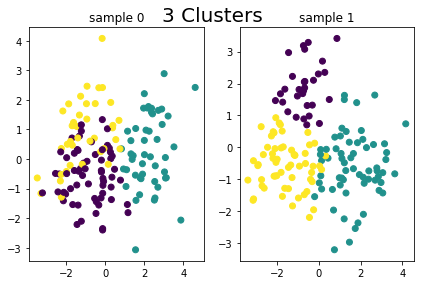

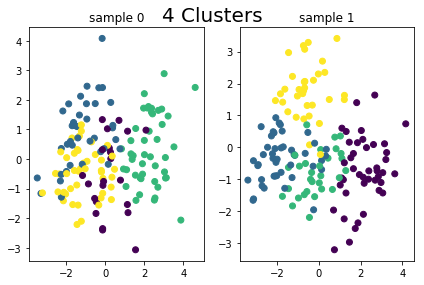

In [17]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

1. Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

Only the 2 cluster solution seems to have any sort of consistency between samples. Both the 3 and 4 cluster solutions are very different from one another in which points get assigned to which cluster. This makes sense though since we are dealing with a two cluster problem. 

In [20]:
# ARI with 2 clusters
full_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
metrics.adjusted_rand_score(y, full_pred)

0.43661540614807665

In [21]:
# ARI with 3 clusters
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
metrics.adjusted_rand_score(y, full_pred)

0.280694132678885

In [23]:
# ARI with 4 clusters
full_pred = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
metrics.adjusted_rand_score(y, full_pred)

0.1968993286830863

2. Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

Again when k equals 2, that is the best model. As k increases it appears the ARI score will keep going down. 

In [24]:
# Silhouette score with 2 clusters
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.17440650461256255


In [25]:
# Silhouette score with 3 clusters
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.12862190702187828


In [26]:
# Silhouette score with 4 clusters
labels = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.13186062012858554


3. Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

Again, at k equals 2 we get the best silhouette score. As mentioned previously since there are only two outcomes this makes sense. 